# Amortized Langevin dynamics

In [103]:
%load_ext autoreload
import sys
sys.path.append("../../learning_particle_gradients/")



import numpy as onp
import jax
from jax import numpy as jnp
from jax import jit, grad, value_and_grad, vmap, config, random, jacfwd
config.update("jax_debug_nans", True)
from jax.ops import index_update, index
import matplotlib.pyplot as plt
from tqdm import tqdm

import haiku as hk
import optax

import distributions
import nets
import plot

key = random.PRNGKey(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [349]:
setup = distributions.funnel
target, proposal = setup.get()

def sample_latent(subkey, num=100):
    return proposal.sample(num, key=subkey)

def generator_fn(latent):
    mlp = nets.MLP([32, 128, 64, 2])
    return mlp(latent)

generator = hk.transform(generator_fn)


key, subkey = random.split(key)
z = sample_latent(subkey)

key, subkey = random.split(key)
init_params = generator.init(subkey, z)

# generator.apply(init_params, subkey, z).shape

In [350]:
# Training

@jit
def step(key, params, stepsize):
    key, subkey = random.split(key)
    z = sample_latent(subkey)
    samples = generator.apply(params, subkey, z) # subkey ignored


    key, subkey = random.split(key)
    noise = random.normal(subkey, samples.shape)
    dkl_dsamples = - stepsize * vmap(grad(target.logpdf))(z) + jnp.sqrt(2*stepsize) * noise


    dsamples_dparam = vmap(jacfwd(generator.apply), (None, None, 0))(params, subkey, z)
    dkl_dparam = jax.tree_map(
        lambda ds_dp: jnp.tensordot(ds_dp, dkl_dsamples, axes=([0, 1], [0, 1])),
        dsamples_dparam)

    updated_params = jax.tree_multimap(lambda a, b: a + b, params, dkl_dparam)
    return updated_params

@jit
def fake_loss(params, key):
    key, subkey = random.split(key)
    z = sample_latent(subkey)
    samples = generator.apply(params, subkey, z) # subkey ignored
    true_samples = target.sample(100, key=key)
    return jnp.sum((samples - true_samples)**2)

In [351]:
params = init_params

100%|██████████| 100/100 [00:00<00:00, 252.88it/s]


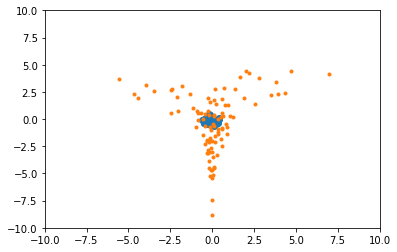

In [361]:
stepsize = 1e-6
# for _ in tqdm(range(1000)):
#     key, subkey = random.split(key)
#     params = step(subkey, params, stepsize)


for _ in tqdm(range(100)):
    key, subkey = random.split(key)
    params = jax.tree_multimap(lambda p, dp: p - stepsize * dp, params, grad(fake_loss)(params, subkey))

key, subkey = random.split(key)
z = sample_latent(subkey)
samples = generator.apply(params, subkey, z)

fig, ax = plt.subplots()
lim = (-10, 10)
ax.set(xlim=lim, ylim=lim)
plot.scatter(samples, ax=ax)
plot.scatter(target.sample(100), ax=ax, marker=".")

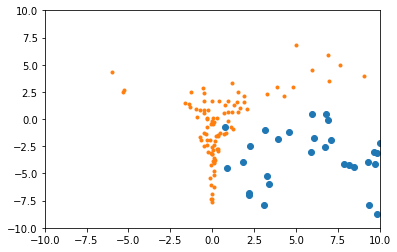

In [237]:
key, subkey = random.split(key)
z = sample_latent(subkey)
samples = generator.apply(init_params, subkey, z)

fig, ax = plt.subplots()
lim = (-10, 10)
ax.set(xlim=lim, ylim=lim)
plot.scatter(samples, ax=ax)
plot.scatter(target.sample(100), ax=ax, marker=".")

### test comparison generator

In [389]:
def init(key):
    return random.normal(key, (2,2)) / 10

def apply(params, subkey):
    """params have shape (2, 2); in general (d,d)"""
    def gen(key):
        z = jnp.squeeze(sample_latent(key, 1))
        return z * jnp.exp(jnp.dot(params, z))
    return vmap(gen)(random.split(subkey, 100))


comparison_generator = hk.Transformed(init, apply)

cparams = comparison_generator.init(subkey)
# comparison_generator.apply(cparams, subkey).shape

@jit
def cfake_loss(cparams, key):
    key, subkey = random.split(key)
    samples = comparison_generator.apply(cparams, subkey)
    true_samples = target.sample(100, key=key)
    return jnp.sum((samples - true_samples)**2)

In [ ]:
cparams = comparison_generator.init(subkey)

In [405]:
key, subkey = random.split(key)
ls = []

stepsize = 1e-11
for _ in tqdm(range(100)):
    key, subkey = random.split(key)
    l, g = value_and_grad(cfake_loss)(cparams, subkey)
    cparams = cparams - stepsize * g
    ls.append(l)

100%|██████████| 100/100 [00:00<00:00, 603.81it/s]


In [406]:
cparams

DeviceArray([[ 0.00813374,  0.2135064 ],
             [-0.14819667,  0.33566436]], dtype=float32)

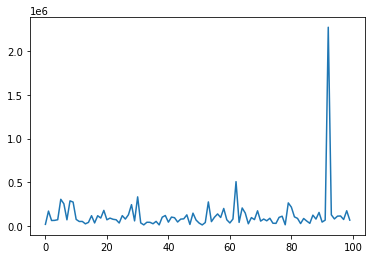

In [407]:
plt.plot(ls)

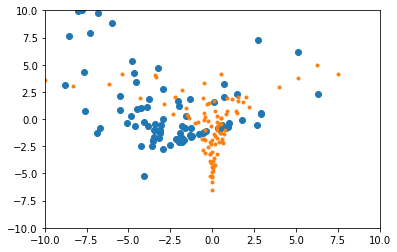

In [408]:
key, subkey = random.split(key)
samples = comparison_generator.apply(cparams, subkey)

fig, ax = plt.subplots()
lim = (-10, 10)
ax.set(xlim=lim, ylim=lim)
plot.scatter(samples, ax=ax)
plot.scatter(target.sample(100), ax=ax, marker=".")